# Triangle Centrality

From the paper by Paul Burkhardt:

[https://arxiv.org/pdf/2105.00110.pdf](https://arxiv.org/pdf/2105.00110.pdf)

"Triangle centrality is introduced for finding important vertices in a graph based on the concentration of triangles surrounding each vertex.  An important vertex in triangle centrality is at the center of many triangles, and therefore it may be in many triangles or none at all."

First construct a symmetric test graph, this is the same graph as Figure 2 in the paper:

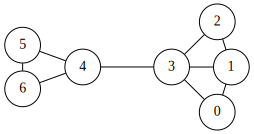

In [1]:
from pygraphblas import  *
from pygraphblas.gviz import *

a = 0
b = 1
c = 2
V = 3
d = 4
e = 5
f = 6

A = Matrix.from_lists(
    [a, a, b, b, c, d, d, d, e],
    [b, V, c, V, V, V, e, f, f],
    1.0, 8, 8)

A = A | A.T # make symmetric

draw(A, directed=False, show_weight=False, graph_attr=dict(layout='sfdp'))

# Version 1

This first version is a straightforward translation of the original algorithm from the paper:

[https://arxiv.org/pdf/2105.00110.pdf#subsection.8.2](https://arxiv.org/pdf/2105.00110.pdf#subsection.8.2)

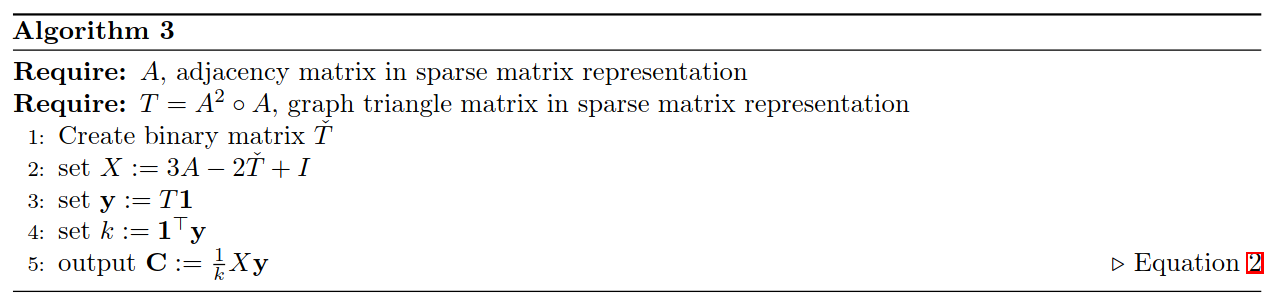

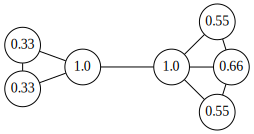

In [2]:

def TC1(A):
    I = Matrix.identity(A.type, A.nrows)
    T = A.mxm(A, mask=A)
    y = T.reduce_vector()
    k = y.reduce_float()
    T_hat = T.pattern(A.type)
    X = (3 * A) - (2 * T_hat) + I
    return (1/k) * (X @ y)

draw(A, label_vector=TC1(A), directed=False, label_width=4, show_weight=False, graph_attr=dict(layout='sfdp'))  

# Version 2

More improvements from Tim Davis:

 - use PLUS_PAIR and transpose the right A in the trangle matrix T, faster since its symmetric, this tells suitesparse to use a faster dot method over saxpy
 - accumulate the reduction of T into a dense Vector, this avoids checking for existence
 - Distribute mxv with y on both sides of the subtraction
 - Compute T_hat implicitly with PLUS_SECOND 


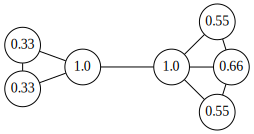

In [3]:
def TC2(A):
    T = A.plus_pair(A, mask=A, desc=descriptor.ST1)
    y = Vector.dense(FP64, A.nrows)
    T.reduce_vector(out=y, accum=FP64.PLUS)
    k = y.reduce_float()
    return (1/k) * (3 * A.plus_second(y) - 2 * T.plus_second(y) + y)


draw(A, label_vector=TC2(A), label_width=4, show_weight=False, directed=False, graph_attr=dict(layout='sfdp'))  

# Version 3 (Lower Triangular)

Tim Davis also proposed a variant that does less work by processing only the lower triangular portion of the matrix.

```
M = tril (A,-1), the lower triangular part (excluding the diagonal, if any)
T<M> = A*A'
y = reduce (T) + reduce (T')
k = 2 * reduce (T)
c = (3 *A*y - 2 * (T*y + T'*y) + y) / k
```


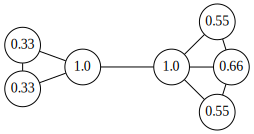

In [4]:
def TC3(A):
    M = A.tril(-1)
    T = A.plus_pair(A, mask=M, desc=descriptor.ST1)
    T_T = T.T
    y = T.reduce() + T_T.reduce()
    k = y.reduce_float()
    return (3 * A.plus_second(y) - (2 * (T.plus_second(y) + T_T.plus_second(y))) + y) / k


draw(A, label_vector=TC3(A), label_width=4, show_weight=False, directed=False, graph_attr=dict(layout='sfdp'))  

# Karate Graph

One of the examples used in the paper is the Zachary Karate Graph.  This is available in the matrix market as 'Newman/karate'

In [5]:
karate = dict(Matrix.ssget('Newman/karate'))['karate.mtx'].cast(FP64)

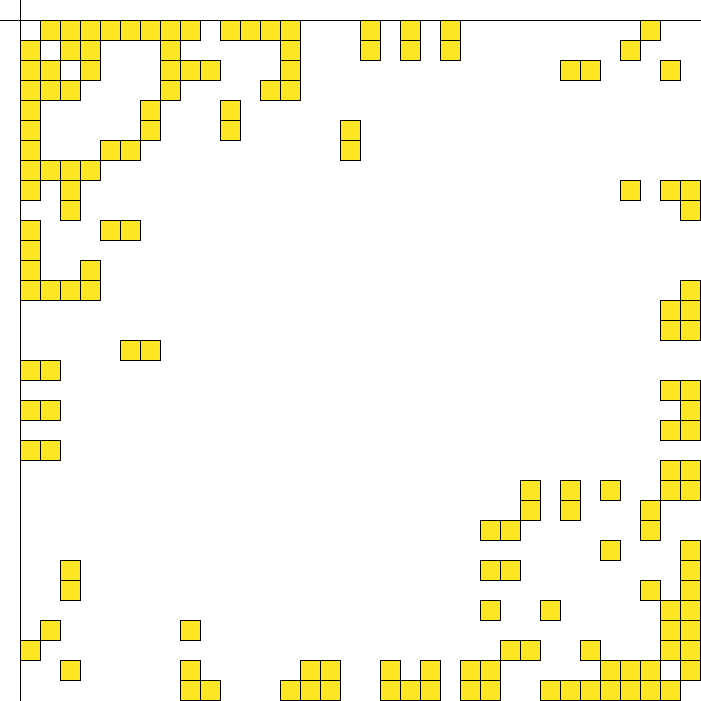

In [6]:
draw_matrix(karate, labels=False, scale=20)

# Micro-benchmarks

In [7]:
%timeit -n 100 -r 100 TC1(karate)

135 µs ± 11.7 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [8]:
%timeit -n 100 -r 100 TC2(karate)

109 µs ± 4.98 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


# Results Agree with Paper

Below is a figure from the paper on the Triangular Centrality (TC) of the Karate Club graph as it compares to Betweenness Centrality (BC), Closeness Centrality (CC), Degree Centrality (DC), Eigenvector Centrality (EV), and Page Rank Centrality (PR).  [See the paper](https://arxiv.org/pdf/2105.00110.pdf#section.11) for detailed comparison results:

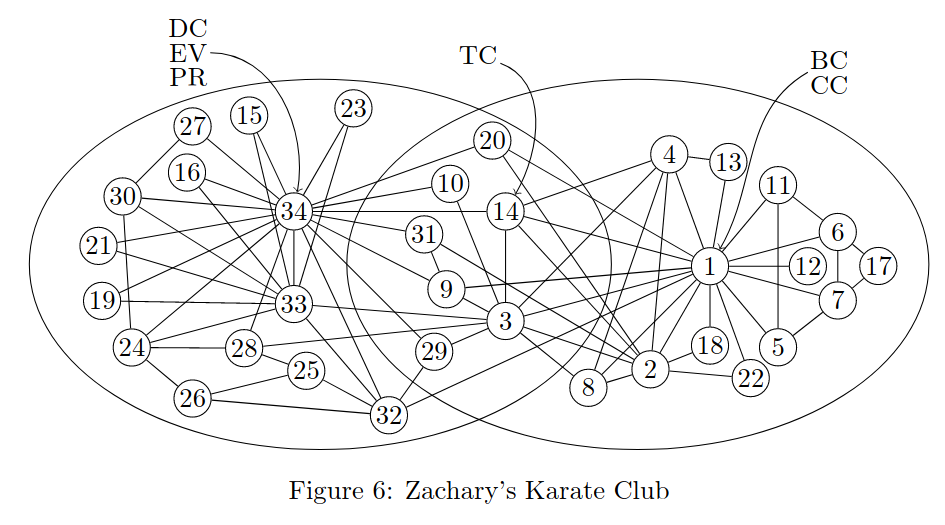

Here each nodes is plotted below with a label of its triangle centrality.  The layout is close enough to be discernable that this shows agreement of the highest ranked node (2.244)

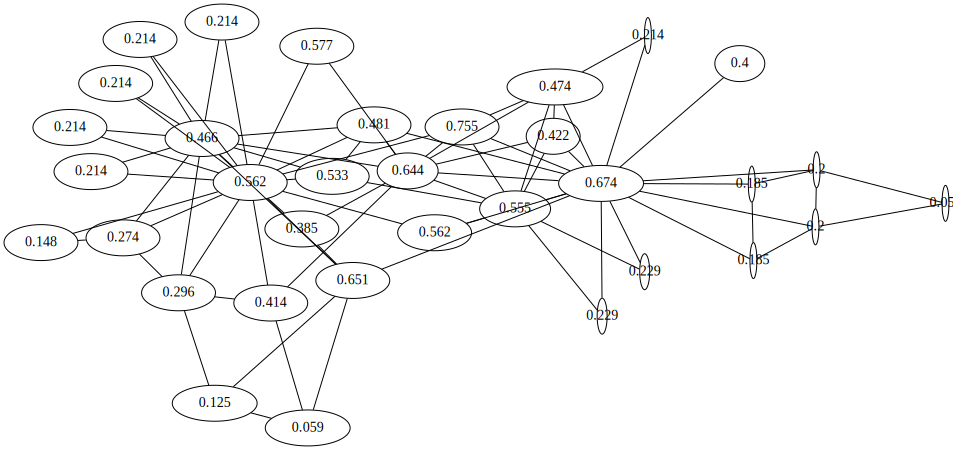

In [15]:
tc = TC3(karate)
draw_graph(karate, directed=False, label_vector=tc, size_vector=tc, size_scale=5, log_scale=True, show_weight=False, label_width=5, graph_attr=dict(layout='sfdp'))

# Performance Results large Graphs

Here are the results from the paper on various graphs (28 core, 256GB):

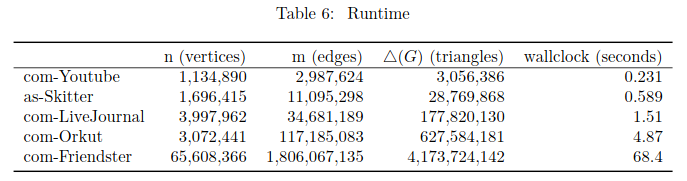

Here are the results for some of the same graphs on a modest laptop (4 core, 32GB)

In [63]:
from collections import defaultdict
from pathlib import Path
from random import seed
from timeit import repeat

graphs = [
    #'Newman/karate',
    #'SNAP/wiki-Vote',
    'SNAP/com-Amazon',
    'SNAP/com-Youtube',
    'SNAP/as-Skitter',
    'SNAP/com-LiveJournal',
    #'SNAP/com-Orkut',
    #'SNAP/com-Friendster',
]

# this is the location of the cache for ssgetpy, pygraphblas will cache much 
# faster binary dumps of matrix market graphs here, change if necessary

ssgetpy_cache = Path('/home/jovyan/.ssgetpy')

def tcount(A):
    "Return the triangle count"
    L = A.tril()
    return L.plus_pair(L, mask=L).reduce_int()


results = defaultdict(dict)
R = 3
N = 1
for name in graphs:
    mname = name.split('/')[1]
    fname = mname + '.mtx'
    G = dict(Matrix.ssget(name, binary_cache_dir=ssgetpy_cache))[fname].cast(FP64)
    _tc = tcount(G)
    results[mname]['tcount'] = _tc
    print(f'{name} has {_tc} triangles')
    for f in [TC2, TC3]:
        print(f'Loading {name}')
        result = repeat(f'f(G)', repeat=R, number=N, globals=locals())
        avg = sum(result) / len(result)
        print(f'{tname} on {name} took ', avg, f'average for {R} runs')
        results[mname][f.__name__] = avg

results

Loading SNAP/com-Amazon
SNAP/com-Amazon has 1851744 triangles
com-LiveJournal-TC3 on SNAP/com-Amazon took  0.10545975765368591 average for 3 runs
Loading SNAP/com-Amazon
SNAP/com-Amazon has 1851744 triangles
com-LiveJournal-TC3 on SNAP/com-Amazon took  0.09826420499787976 average for 3 runs
Loading SNAP/com-Youtube
SNAP/com-Youtube has 5975248 triangles
com-LiveJournal-TC3 on SNAP/com-Youtube took  0.691771880335485 average for 3 runs
Loading SNAP/com-Youtube
SNAP/com-Youtube has 5975248 triangles
com-LiveJournal-TC3 on SNAP/com-Youtube took  0.43804903033499915 average for 3 runs
Loading SNAP/as-Skitter
SNAP/as-Skitter has 22190596 triangles
com-LiveJournal-TC3 on SNAP/as-Skitter took  2.23327697297403 average for 3 runs
Loading SNAP/as-Skitter
SNAP/as-Skitter has 22190596 triangles
com-LiveJournal-TC3 on SNAP/as-Skitter took  1.4994719883349414 average for 3 runs
Loading SNAP/com-LiveJournal
SNAP/com-LiveJournal has 69362378 triangles
com-LiveJournal-TC3 on SNAP/com-LiveJournal took 

defaultdict(dict,
            {'com-Amazon': {'tcount': 667129,
              'TC2': 0.10545975765368591,
              'TC3': 0.09826420499787976},
             'com-Youtube': {'tcount': 3056386,
              'TC2': 0.691771880335485,
              'TC3': 0.43804903033499915},
             'as-Skitter': {'tcount': 28769868,
              'TC2': 2.23327697297403,
              'TC3': 1.4994719883349414},
             'com-LiveJournal': {'tcount': 177820130,
              'TC2': 10.504229484397607,
              'TC3': 6.759752101652945}})

[0.10545975765368591, 0.09826420499787976, 0.691771880335485, 0.43804903033499915, 2.23327697297403, 1.4994719883349414, 10.504229484397607, 6.759752101652945]
[1, 2, 3, 5, 6, 7, 9, 10]


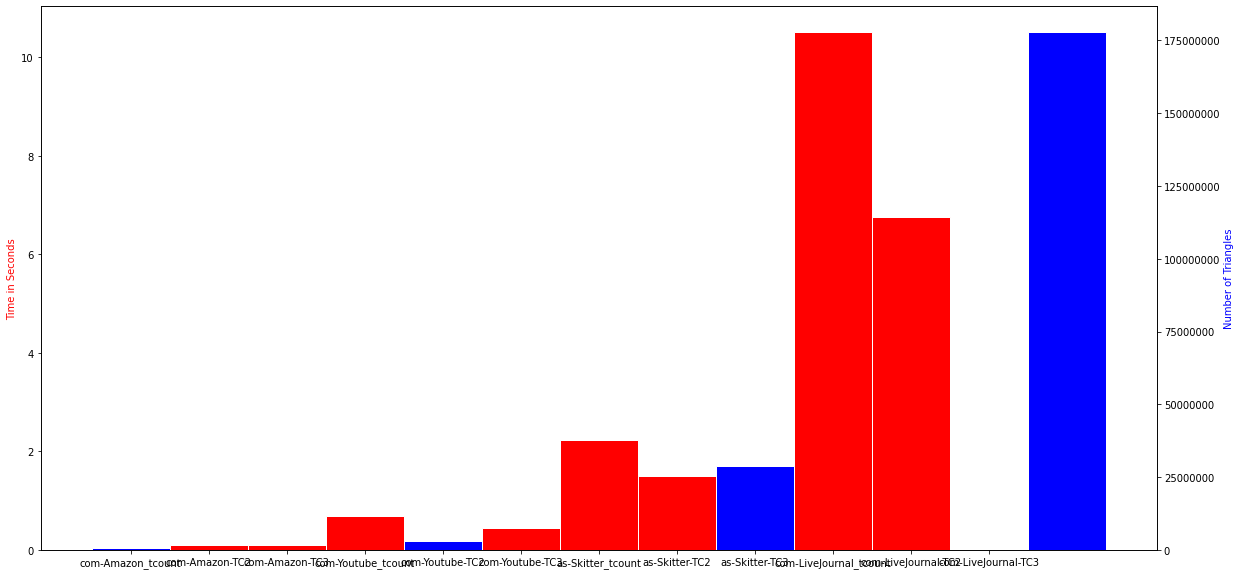

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter as i
 
plt.rcParams['figure.figsize'] = [20, 10]
barWidth = 1

labels = ['-'.join([g, f]) if f != 'tcount' else g + '_' + f for g in results for f in results[g]]
counts = [results[g]['tcount'] for g in results]
times = [results[g][f] for g in results for f in results[g] if f != 'tcount']
print(times)
r1 = [i for i in range(11) if i % len(results) != 0]
print(r1)
r2 = np.arange(len(counts)) * len(results) * barWidth

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(r1, times, color='red', width=barWidth, edgecolor='white', label='Time')
ax1.set_ylabel('Time in Seconds', color='red')
ax2.bar(r2, counts, color='blue', width=barWidth, edgecolor='white', label='Triangle Count')
ax2.set_ylabel('Number of Triangles', color='blue')
ax2.ticklabel_format(style='plain') 

plt.xticks(list(range(len(labels))), labels)
plt.show()